# Assignment 1: Sampler Synthesis — Starter Code

This notebook provides baseline implementations of Random Walk Metropolis-Hastings and HMC using [BlackJAX](https://blackjax-devs.github.io/blackjax/). Use these as reference points for your novel sampler.

**Your task**: Design, implement, and analyze a novel MCMC sampler. Compare it to these baselines on the benchmark distributions.

In [1]:
import arviz as az
import blackjax
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["font.size"] = 12

---
## Benchmark Distribution: Rosenbrock (Banana)

The Rosenbrock distribution has a curved, narrow ridge that tests how well samplers handle strong correlations and curved geometry. This is challenging because:
- The high-probability region is thin and curved
- Random walk proposals often step off the ridge
- Samplers need to follow the curved geometry efficiently

In [2]:
def log_prob_rosenbrock(theta):
    """Rosenbrock (banana) distribution.

    log p(x, y) ∝ -(1-x)²/20 - (y - x²)²

    This creates a curved, banana-shaped distribution that tests
    how well samplers handle strong correlations and curved geometry.
    """
    x, y = theta[0], theta[1]
    return -0.05 * (1 - x) ** 2 - (y - x**2) ** 2

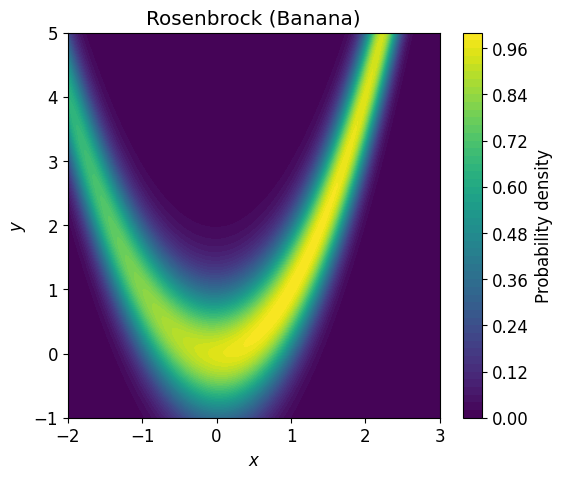

In [3]:
def plot_distribution(log_prob_fn, title, xlim=(-4, 4), ylim=(-4, 4)):
    """Visualize a 2D log probability distribution."""
    x = jnp.linspace(*xlim, 200)
    y = jnp.linspace(*ylim, 200)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)

    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(X, Y, jnp.exp(log_probs), levels=50, cmap="viridis")
    plt.colorbar(label="Probability density")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plt.title(title)
    plt.show()


plot_distribution(log_prob_rosenbrock, "Rosenbrock (Banana)", xlim=(-2, 3), ylim=(-1, 5))

---
## Baseline 1: Random Walk Metropolis-Hastings

The simplest MCMC method. Proposes isotropic Gaussian steps — no gradient information.

**Tuning tip:** Target ~23-50% acceptance rate. Higher isn't better — it means steps are too small.

In [4]:
def run_rwmh(key, log_prob_fn, initial_position, sigma, n_samples):
    """Run Random Walk Metropolis-Hastings using BlackJAX.

    Args:
        key: JAX random key
        log_prob_fn: Log probability function
        initial_position: Starting point, shape (D,)
        sigma: Proposal standard deviation (scalar or array)
        n_samples: Number of samples to draw

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    # Initialize the sampler with a normal proposal distribution
    rmh = blackjax.rmh(log_prob_fn, blackjax.mcmc.random_walk.normal(sigma))
    initial_state = rmh.init(initial_position)

    # Build the sampling loop
    @jax.jit
    def one_step(state, key):
        state, info = rmh.step(key, state)
        return state, (state.position, info.is_accepted)

    # Run the chain
    keys = jr.split(key, n_samples)
    _, (samples, accepted) = jax.lax.scan(one_step, initial_state, keys)

    return samples, accepted.mean()

---
## Baseline 2: Hamiltonian Monte Carlo (HMC)

Uses gradient information to make informed proposals. Typically much more efficient than random walk.

**Tuning tip:** Target ~65-90% acceptance rate. Tune step_size first, then n_leapfrog.

In [5]:
def run_hmc(key, log_prob_fn, initial_position, step_size, n_leapfrog, n_samples):
    """Run HMC using BlackJAX.

    Args:
        key: JAX random key
        log_prob_fn: Log probability function
        initial_position: Starting point, shape (D,)
        step_size: Leapfrog step size (epsilon)
        n_leapfrog: Number of leapfrog steps per iteration
        n_samples: Number of samples to draw

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    # Initialize the sampler (identity mass matrix)
    inverse_mass_matrix = jnp.ones(initial_position.shape[0])
    hmc = blackjax.hmc(
        log_prob_fn,
        step_size=step_size,
        inverse_mass_matrix=inverse_mass_matrix,
        num_integration_steps=n_leapfrog,
    )
    initial_state = hmc.init(initial_position)

    # Build the sampling loop
    @jax.jit
    def one_step(state, key):
        state, info = hmc.step(key, state)
        return state, (state.position, info.acceptance_rate)

    # Run the chain
    keys = jr.split(key, n_samples)
    _, (samples, accepted) = jax.lax.scan(one_step, initial_state, keys)

    return samples, accepted.mean()

---
## Run Baselines on Rosenbrock

In [6]:
key = jr.PRNGKey(42)
key1, key2 = jr.split(key)

initial_pos = jnp.array([0.0, 0.0])
n_samples = 50_000

# Random Walk MH
rwmh_samples, rwmh_acc = run_rwmh(key1, log_prob_rosenbrock, initial_pos, sigma=1.0, n_samples=n_samples)
print(f"RWMH acceptance rate: {rwmh_acc:.2%}")

# HMC
hmc_samples, hmc_acc = run_hmc(
    key2, log_prob_rosenbrock, initial_pos, step_size=0.2, n_leapfrog=10, n_samples=n_samples
)
print(f"HMC acceptance rate: {hmc_acc:.2%}")

RWMH acceptance rate: 50.02%
HMC acceptance rate: 74.78%


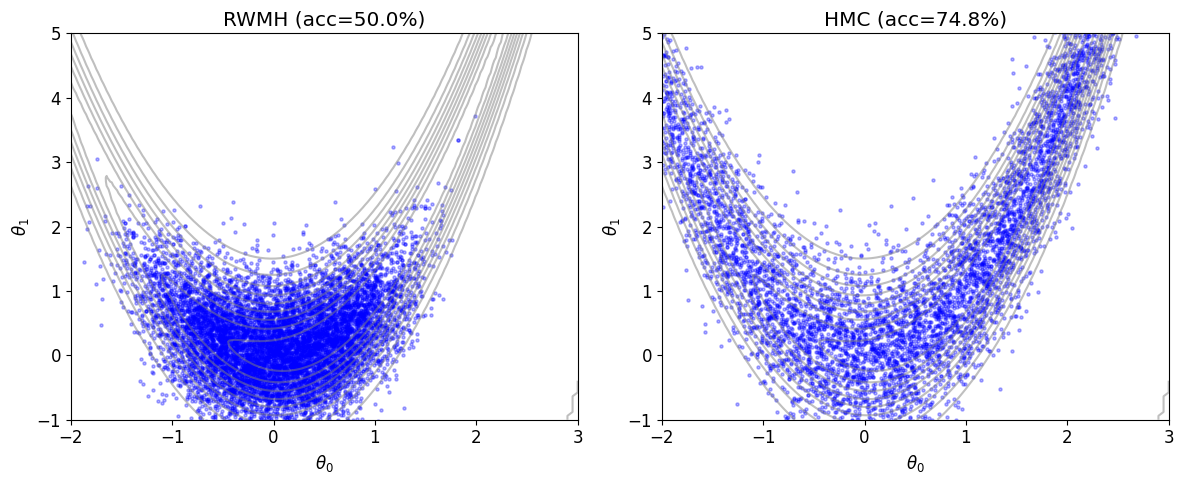

In [7]:
def plot_samples_comparison(samples1, samples2, label1, label2, log_prob_fn, xlim, ylim):
    """Plot samples from two methods side by side."""
    # Compute contours
    x = jnp.linspace(*xlim, 100)
    y = jnp.linspace(*ylim, 100)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)
    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, samples, label in zip(axes, [samples1, samples2], [label1, label2]):
        ax.contour(X, Y, jnp.exp(log_probs), levels=10, colors="gray", alpha=0.5)
        ax.scatter(samples[::5, 0], samples[::5, 1], alpha=0.3, s=5, c="blue")
        ax.set_xlabel(r"$\theta_0$")
        ax.set_ylabel(r"$\theta_1$")
        ax.set_title(label)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    plt.tight_layout()
    plt.show()


plot_samples_comparison(
    rwmh_samples,
    hmc_samples,
    f"RWMH (acc={rwmh_acc:.1%})",
    f"HMC (acc={hmc_acc:.1%})",
    log_prob_rosenbrock,
    xlim=(-2, 3),
    ylim=(-1, 5),
)

---
## Diagnostics with ArviZ

[ArviZ](https://python.arviz.org/) provides standard MCMC diagnostics. Key metrics:
- **Acceptance rate**: Too low = proposals too aggressive; too high = proposals too timid
- **Effective Sample Size (ESS)**: How many independent samples you effectively have
- **Trace plots**: Visual check for mixing and stationarity
- **Autocorrelation**: How correlated successive samples are

In [8]:
def samples_to_inference_data(samples, var_names=None):
    """Convert samples array to ArviZ InferenceData.

    Args:
        samples: Array of shape (n_samples, n_dims)
        var_names: Optional list of variable names

    Returns:
        ArviZ InferenceData object
    """
    if var_names is None:
        var_names = [f"theta_{i}" for i in range(samples.shape[1])]

    # ArviZ expects dict of {var_name: array} with shape (n_chains, n_samples)
    data_dict = {name: samples[None, :, i] for i, name in enumerate(var_names)}
    return az.convert_to_inference_data(data_dict)


def summarize_sampler(samples, name, var_names=None):
    """Print summary statistics for samples using ArviZ."""
    idata = samples_to_inference_data(samples, var_names)
    print(f"\n=== {name} ===")
    display(az.summary(idata, kind="stats"))
    display(az.ess(idata)) #新增的代码，为了看ESS

In [9]:
# Rosenbrock diagnostics
var_names = ["x", "y"]

rwmh_idata = samples_to_inference_data(rwmh_samples, var_names)
hmc_idata = samples_to_inference_data(hmc_samples, var_names)

# Summary statistics (mean, sd, ESS)
summarize_sampler(rwmh_samples, "RWMH — Rosenbrock", var_names)
summarize_sampler(hmc_samples, "HMC — Rosenbrock", var_names)


=== RWMH — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%
x,0.048,0.637,-1.105,1.206
y,0.266,0.659,-0.982,1.497


<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    x        float64 8B 1.7e+04
    y        float64 8B 1.809e+04
Attributes:
    created_at:     2026-02-18T21:05:29.716496+00:00
    arviz_version:  0.23.1


=== HMC — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%
x,0.456,2.202,-3.390,4.018
y,4.970,5.012,-0.379,15.324


<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    x        float64 8B 41.64
    y        float64 8B 93.39
Attributes:
    created_at:     2026-02-18T21:05:29.796089+00:00
    arviz_version:  0.23.1

RWMH Trace Plots:


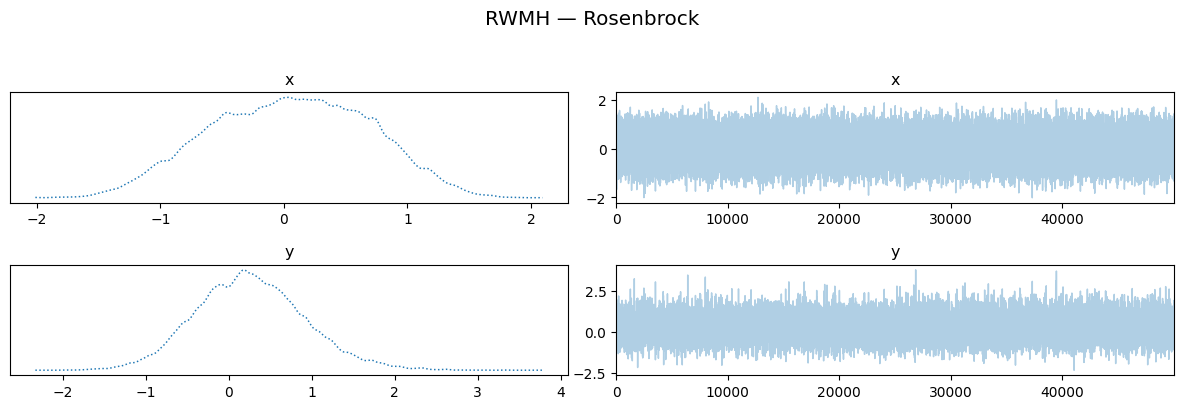


HMC Trace Plots:


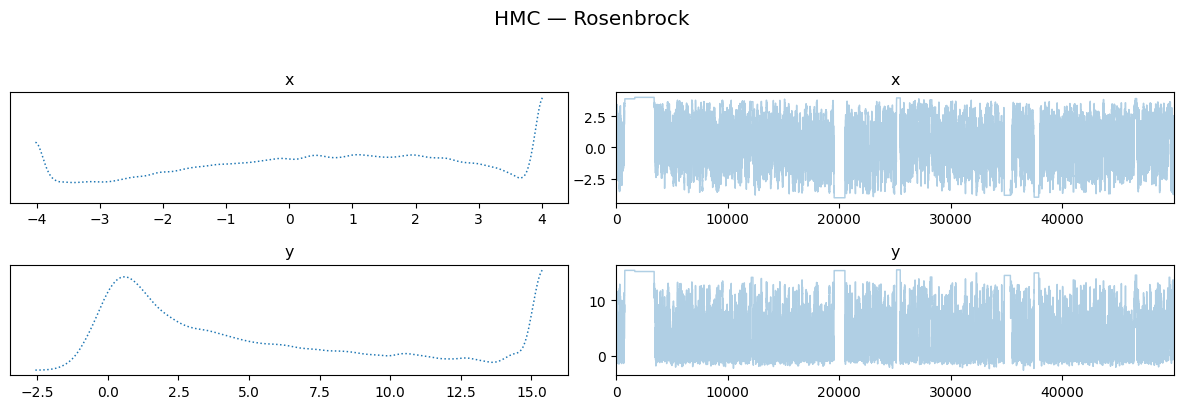

In [10]:
# Trace plots — Rosenbrock
print("RWMH Trace Plots:")
az.plot_trace(rwmh_idata, combined=True, figsize=(12, 4))
plt.suptitle("RWMH — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

print("\nHMC Trace Plots:")
az.plot_trace(hmc_idata, combined=True, figsize=(12, 4))
plt.suptitle("HMC — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

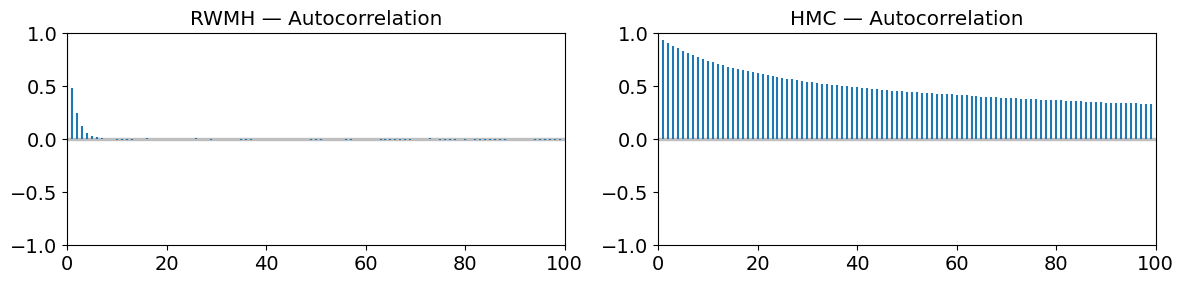

In [11]:
# Autocorrelation — Rosenbrock
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
az.plot_autocorr(rwmh_idata, ax=axes[0], combined=True)
axes[0].set_title("RWMH — Autocorrelation")
az.plot_autocorr(hmc_idata, ax=axes[1], combined=True)
axes[1].set_title("HMC — Autocorrelation")
plt.tight_layout()
plt.show()

---
## Discussion: Why Does RWMH Struggle Here?

Look carefully at the results above. You might notice something surprising: RWMH has *lower* autocorrelation than HMC, yet HMC explores the distribution much better. What's going on?

**The issue is local vs. global mixing.** RWMH with isotropic proposals faces a dilemma on curved distributions like the Rosenbrock:
- If the proposal scale is small enough to stay on the narrow ridge, it can't move far along the banana
- If the proposal scale is large enough to explore, most proposals step off the ridge and get rejected

So RWMH ends up jittering locally — samples decorrelate quickly *within* its local neighborhood, but it never traverses the full banana. Low autocorrelation doesn't mean good exploration!

**HMC uses gradients to follow the curve.** It makes long, coherent moves along the ridge without stepping off. The high autocorrelation is just because consecutive samples are along the same trajectory — but they're actually covering the full posterior.

This is exactly the kind of geometry where HMC shines, and one of the main motivations for gradient-based samplers.

---
## Benchmark Distribution 2: Neal's Funnel

Neal's Funnel is a hierarchical distribution that varies dramatically in scale across the space. The narrow "neck" of the funnel is notoriously difficult for fixed step-size samplers.

$$v \sim \mathcal{N}(0, 9), \quad x \sim \mathcal{N}(0, e^v)$$

This means:
- When $v$ is large and positive, $x$ can vary widely
- When $v$ is large and negative, $x$ is tightly constrained near 0
- A single step size can't work well everywhere

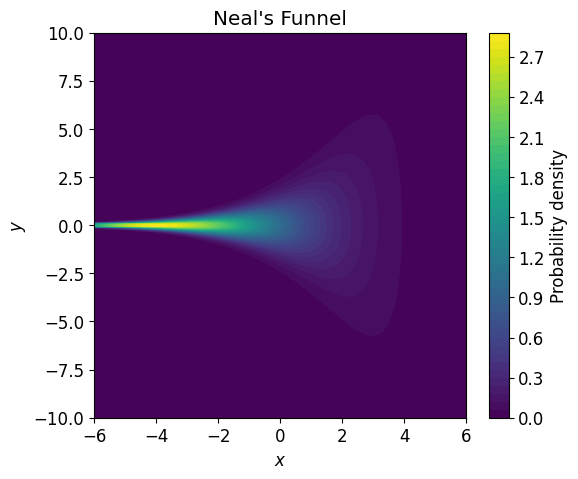

In [12]:
def log_prob_funnel(theta):
    """Neal's Funnel distribution.

    v ~ N(0, 9)
    x ~ N(0, exp(v))

    This creates a funnel shape where the scale of x depends on v.
    The narrow neck (small v) is very hard to sample.
    """
    v, x = theta[0], theta[1]
    log_p_v = -0.5 * v**2 / 9  # v ~ N(0, 9)
    log_p_x_given_v = -0.5 * x**2 * jnp.exp(-v) - 0.5 * v  # x ~ N(0, exp(v))
    return log_p_v + log_p_x_given_v


plot_distribution(log_prob_funnel, "Neal's Funnel", xlim=(-6, 6), ylim=(-10, 10))

In [13]:
# TODO: Run the RWMH and HMC baselines on Neal's Funnel
# Use the same workflow as Rosenbrock above — you'll need to tune hyperparameters!

In [13]:
# =========================
# Run baselines on Neal's Funnel
# =========================
key = jr.PRNGKey(42)
key1, key2 = jr.split(key)

# start point
initial_pos = jnp.array([0.0, 0.0])
n_samples = 50_000

# --- RWMH ---
rwmh_sigma = 3.1
funnel_rwmh_samples, funnel_rwmh_acc = run_rwmh(
    key1, log_prob_funnel, initial_pos, sigma=rwmh_sigma, n_samples=n_samples
)
print(f"Funnel RWMH acceptance rate: {funnel_rwmh_acc:.2%}")

# --- HMC ---
hmc_step_size = 0.25
hmc_n_leapfrog = 25
funnel_hmc_samples, funnel_hmc_acc = run_hmc(
    key2, log_prob_funnel, initial_pos,
    step_size=hmc_step_size, n_leapfrog=hmc_n_leapfrog, n_samples=n_samples
)
print(f"Funnel HMC acceptance rate: {funnel_hmc_acc:.2%}")

Funnel RWMH acceptance rate: 23.08%
Funnel HMC acceptance rate: 81.68%


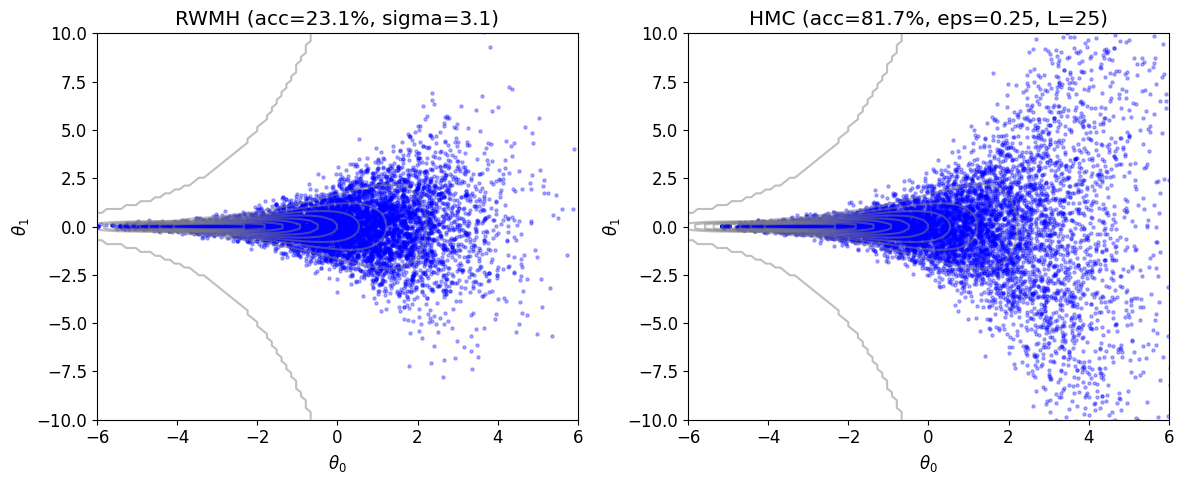

In [14]:
plot_samples_comparison(
    funnel_rwmh_samples,
    funnel_hmc_samples,
    f"RWMH (acc={funnel_rwmh_acc:.1%}, sigma={rwmh_sigma})",
    f"HMC (acc={funnel_hmc_acc:.1%}, eps={hmc_step_size}, L={hmc_n_leapfrog})",
    log_prob_funnel,
    xlim=(-6, 6),
    ylim=(-10, 10),
)

In [15]:
# =========================
# Diagnostics with ArviZ (Funnel)
# =========================
var_names = ["v", "x"]

rwmh_idata = samples_to_inference_data(funnel_rwmh_samples, var_names)
hmc_idata  = samples_to_inference_data(funnel_hmc_samples, var_names)

# Summary (mean, sd, ESS)
summarize_sampler(funnel_rwmh_samples, "RWMH — Funnel", var_names)
summarize_sampler(funnel_hmc_samples,  "HMC  — Funnel", var_names)


=== RWMH — Funnel ===


,mean,sd,hdi_3%,hdi_97%
v,-0.390,1.985,-4.424,3.100
x,0.005,1.212,-2.442,2.463


<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    v        float64 8B 3.29e+03
    x        float64 8B 8.835e+03
Attributes:
    created_at:     2026-02-18T21:06:06.296209+00:00
    arviz_version:  0.23.1


=== HMC  — Funnel ===


,mean,sd,hdi_3%,hdi_97%
v,0.214,2.722,-4.762,5.047
x,-0.024,5.848,-8.384,8.105


<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    v        float64 8B 1.599e+03
    x        float64 8B 6.897e+03
Attributes:
    created_at:     2026-02-18T21:06:06.358876+00:00
    arviz_version:  0.23.1

RWMH Trace Plots — Funnel:


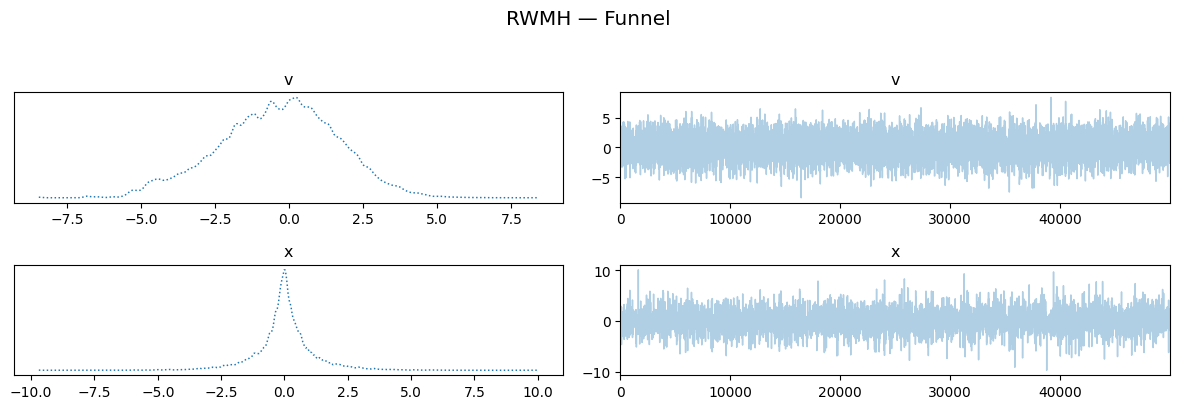


HMC Trace Plots — Funnel:


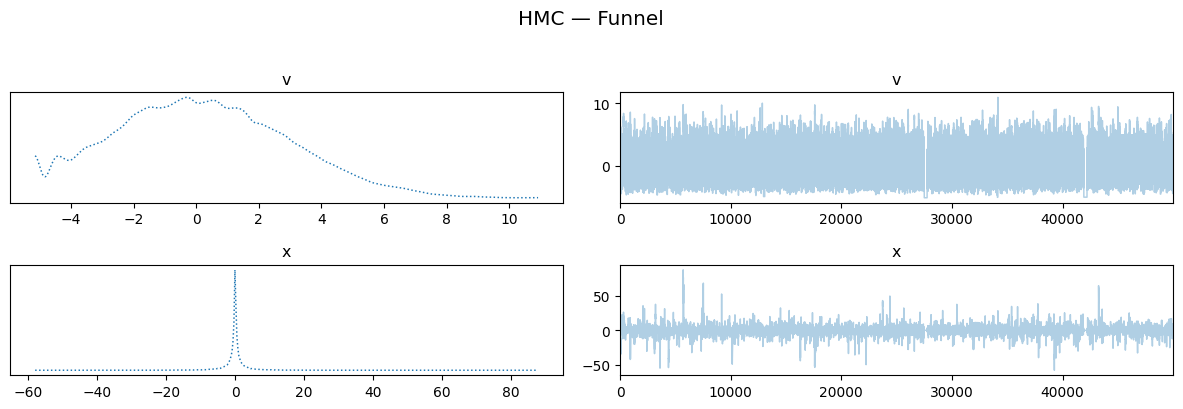

In [16]:
# ===============================
# Trace plots — Funnel
# ===============================
print("RWMH Trace Plots — Funnel:")
az.plot_trace(rwmh_idata, combined=True, figsize=(12, 4))
plt.suptitle("RWMH — Funnel", y=1.02)
plt.tight_layout()
plt.show()

print("\nHMC Trace Plots — Funnel:")
az.plot_trace(hmc_idata, combined=True, figsize=(12, 4))
plt.suptitle("HMC — Funnel", y=1.02)
plt.tight_layout()
plt.show()


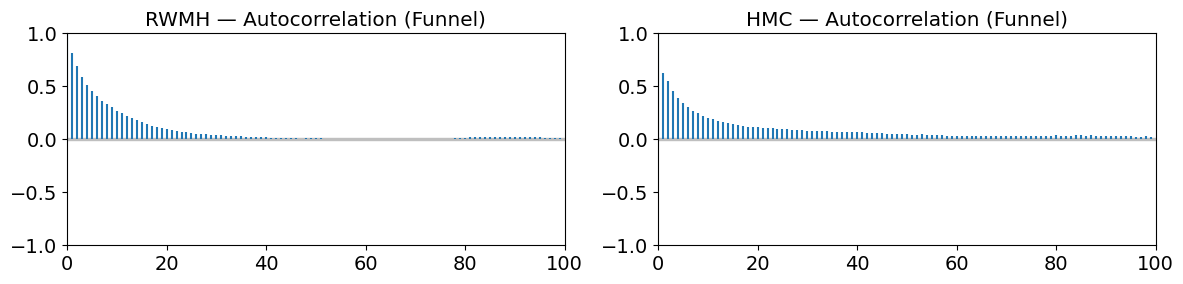

In [17]:
# ===============================
# Autocorrelation — Funnel
# ===============================
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
az.plot_autocorr(rwmh_idata, ax=axes[0], combined=True)
axes[0].set_title("RWMH — Autocorrelation (Funnel)")
az.plot_autocorr(hmc_idata, ax=axes[1], combined=True)
axes[1].set_title("HMC — Autocorrelation (Funnel)")
plt.tight_layout()
plt.show()

---
## Your Novel Sampler

Now it's your turn! Implement your own sampler below. Some ideas:

- **Adaptive proposals**: Adjust step size based on acceptance rate or local curvature
- **Hybrid methods**: Combine different move types (e.g., local + global moves)
- **Modified dynamics**: Change the Hamiltonian, use different integrators, add friction
- **Tempering**: Use temperature schedules to help exploration

A simple idea with thorough analysis beats a complex idea you don't understand!

In [48]:
# TODO: Test your sampler on both benchmarks (Rosenbrock and Neal's Funnel)
# my_samples, my_acc = run_my_sampler(key, log_prob_rosenbrock, initial_pos, n_samples=50_000, ...)

In [49]:
# TODO: Test your sampler on Rosenbrock
# my_samples, my_acc = run_my_sampler(key, log_prob_rosenbrock, initial_pos, n_samples=50_000, ...)

In [84]:
# TODO: Compare to baselines
# - Visualize samples (scatter plot with contours)
# - Compute ESS using samples_to_inference_data() and az.summary()
# - Plot traces and autocorrelation
# - Discuss: where does your method work well? Where does it struggle?

In [85]:
# TODO: Ablation study
# - What are the key hyperparameters of your method?
# - How sensitive is performance to each one?
# - What happens in limiting cases (e.g., turning off a component)?

In [18]:
import blackjax
import jax
import jax.numpy as jnp
import jax.random as jr

def run_my_sampler_mixture_rwmh(
    key,
    log_prob_fn,
    initial_position,
    n_samples,
    sigma_local=(1.0, 1.0),  # 每维 local 步长（长度=dim）
    p_global=0.1,            # 使用 global jump 的概率
    sigma_global=5.0,        # global jump 的标量尺度（各向同性）
    return_aux=False,        # True: 额外返回 global 使用比例等
):
    initial_position = jnp.asarray(initial_position)
    dim = initial_position.shape[0]

    # --- local: per-dimension random walk ---
    local_sigma_vec = jnp.asarray(sigma_local)
    if local_sigma_vec.shape[0] != dim:
        raise ValueError(f"sigma_local must have length {dim}, got {local_sigma_vec.shape}")

    local_kernel = blackjax.rmh(
        log_prob_fn,
        blackjax.mcmc.random_walk.normal(local_sigma_vec)
    )

    # --- global: isotropic random walk (vector form to avoid ambiguity) ---
    global_sigma_vec = jnp.ones(dim) * sigma_global
    global_kernel = blackjax.rmh(
        log_prob_fn,
        blackjax.mcmc.random_walk.normal(global_sigma_vec)
    )

    state = local_kernel.init(initial_position)

    @jax.jit
    def one_step(state, key):
        k_choose, k_step = jr.split(key, 2)
        use_global = jr.uniform(k_choose) < p_global

        def do_global(k):
            new_state, info = global_kernel.step(k, state)
            return new_state, (new_state.position, info.is_accepted, True)

        def do_local(k):
            new_state, info = local_kernel.step(k, state)
            return new_state, (new_state.position, info.is_accepted, False)

        new_state, out = jax.lax.cond(use_global, do_global, do_local, k_step)
        return new_state, out

    keys = jr.split(key, n_samples)
    _, (samples, accepted, used_global) = jax.lax.scan(one_step, state, keys)

    acc_rate = accepted.mean()
    global_rate = used_global.mean()

    if return_aux:
        aux = {
            "acceptance_rate": acc_rate,
            "global_used_rate": global_rate,
            "sigma_local": local_sigma_vec,
            "sigma_global": sigma_global,
            "p_global": p_global,
        }
        return samples, aux

    return samples, acc_rate

In [19]:
# =========================
# My sampler on Rosenbrock
# =========================
key = jr.PRNGKey(42)
initial_pos = jnp.array([0.0, 0.0])
n_samples = 50_000

my_samples_rb, my_aux_rb = run_my_sampler_mixture_rwmh(
    key,
    log_prob_rosenbrock,
    initial_pos,
    n_samples=n_samples,
    sigma_local=(1.0, 1.0),
    p_global=0.1,
    sigma_global=1.0,
    return_aux=True,
)

print(f"My sampler acceptance rate on Rosenbrock: {my_aux_rb['acceptance_rate']:.2%}")
print(f"My sampler global jump rate on Rosenbrock: {my_aux_rb['global_used_rate']:.2%}")


My sampler acceptance rate on Rosenbrock: 49.98%
My sampler global jump rate on Rosenbrock: 9.94%


In [20]:
# =========================
# My sampler on Neal's Funnel
# =========================
key = jr.PRNGKey(42)
initial_pos = jnp.array([0.0, 0.0])  # [v, x]
n_samples = 50_000

my_samples_fn, my_aux_fn = run_my_sampler_mixture_rwmh(
    key,
    log_prob_funnel,
    initial_pos,
    n_samples=n_samples,
    sigma_local=(5.0, 0.8),
    p_global=0.5,
    sigma_global=3.0,
    return_aux=True,
)

print(f"My sampler acceptance rate on Neal's Funnel: {my_aux_fn['acceptance_rate']:.2%}")
print(f"My sampler global jump rate on Neal's Funnel: {my_aux_fn['global_used_rate']:.2%}")

My sampler acceptance rate on Neal's Funnel: 26.24%
My sampler global jump rate on Neal's Funnel: 49.68%


In [21]:
def plot_three_samples_comparison(
    samples1, samples2, samples3,
    label1, label2, label3,
    log_prob_fn,
    xlim=(-4, 4),
    ylim=(-4, 4),
    n_grid=120,
    levels=10,
    stride=5,
):
    """
    Plot samples from three methods side by side (1x3) with target contours.
    samples*: array (n_samples, 2)
    log_prob_fn: callable(theta)->logp, theta shape (2,)
    """

    # ----- compute contour grid -----
    x = jnp.linspace(*xlim, n_grid)
    y = jnp.linspace(*ylim, n_grid)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)  # (n_grid^2, 2)

    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    # ----- plot -----
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False, sharey=False)

    for ax, samples, label in zip(
        axes,
        [samples1, samples2, samples3],
        [label1, label2, label3],
    ):
        ax.contour(X, Y, jnp.exp(log_probs), levels=levels, colors="gray", alpha=0.5)
        ax.scatter(samples[::stride, 0], samples[::stride, 1], s=5, alpha=0.3)
        ax.set_title(label)
        ax.set_xlabel(r"$\theta_0$")
        ax.set_ylabel(r"$\theta_1$")
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    plt.tight_layout()
    plt.show()


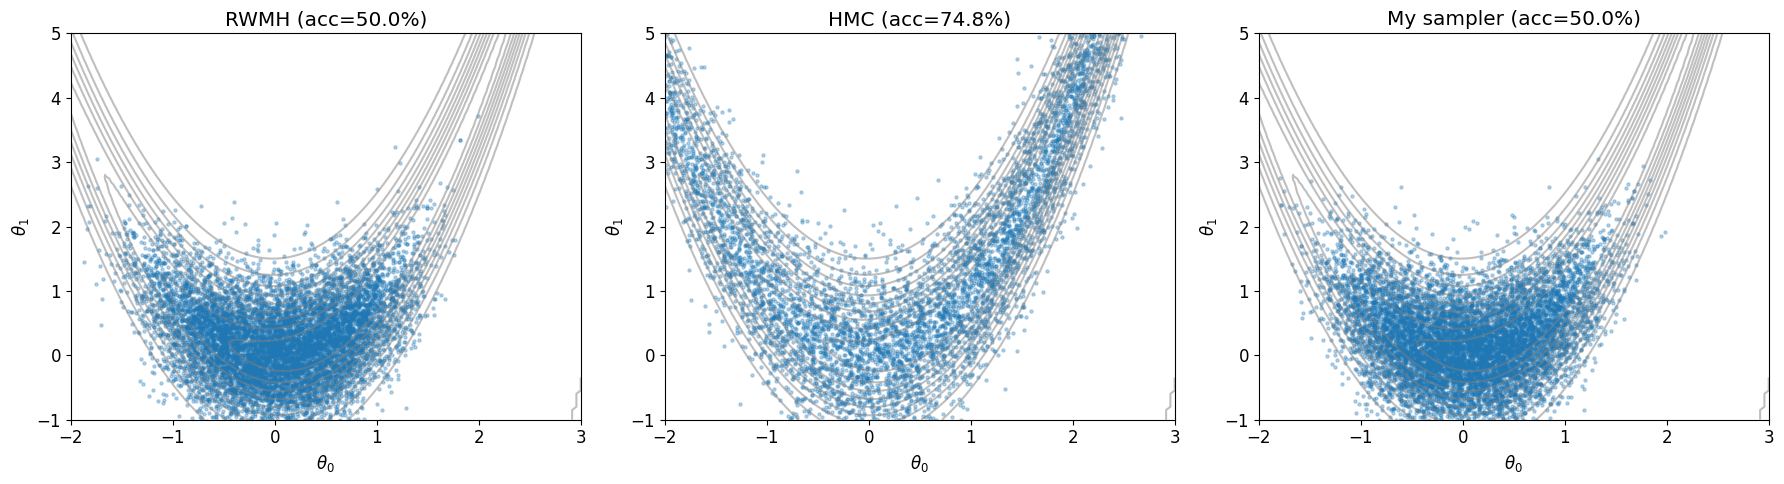

In [22]:
plot_three_samples_comparison(
    rwmh_samples,
    hmc_samples,
    my_samples_rb,
    f"RWMH (acc={rwmh_acc:.1%})",
    f"HMC (acc={hmc_acc:.1%})",
    f"My sampler (acc={my_aux_rb['acceptance_rate']:.1%})",
    log_prob_rosenbrock,
    xlim=(-2, 3),
    ylim=(-1, 5),
    stride=5,
)

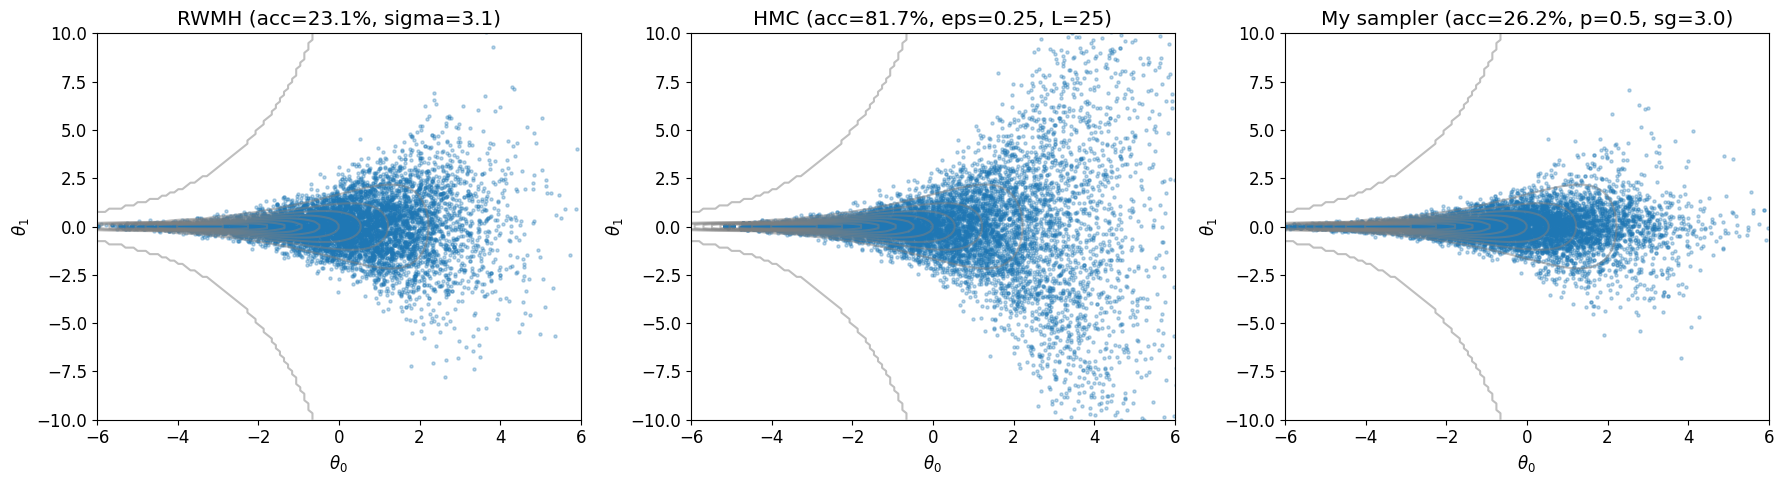

In [23]:
plot_three_samples_comparison(
    funnel_rwmh_samples,
    funnel_hmc_samples,
    my_samples_fn,
    f"RWMH (acc={funnel_rwmh_acc:.1%}, sigma={rwmh_sigma})",
    f"HMC (acc={funnel_hmc_acc:.1%}, eps={hmc_step_size}, L={hmc_n_leapfrog})",
    f"My sampler (acc={my_aux_fn['acceptance_rate']:.1%}, p={my_aux_fn['p_global']}, sg={my_aux_fn['sigma_global']})",
    log_prob_funnel,
    xlim=(-6, 6),
    ylim=(-10, 10),
    stride=5,
)

In [24]:
# =========================
# My sampler diagnostics — Rosenbrock
# =========================
var_names = ["x", "y"]
my_idata_rb = samples_to_inference_data(my_samples_rb, var_names)

# Summary statistics (mean, sd, ESS)
summarize_sampler(my_samples_rb, "My sampler — Rosenbrock", var_names)


# =========================
# My sampler diagnostics — Neal's Funnel
# =========================
var_names_fn = ["v", "x"]   # funnel position = [v, x]
my_idata_fn = samples_to_inference_data(my_samples_fn, var_names_fn)

summarize_sampler(my_samples_fn, "My sampler — Neal's Funnel", var_names_fn)


=== My sampler — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%
x,0.039,0.640,-1.130,1.188
y,0.269,0.663,-0.972,1.493


<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    x        float64 8B 1.692e+04
    y        float64 8B 1.835e+04
Attributes:
    created_at:     2026-02-18T21:06:47.492849+00:00
    arviz_version:  0.23.1


=== My sampler — Neal's Funnel ===


,mean,sd,hdi_3%,hdi_97%
v,-0.914,2.134,-5.212,2.854
x,-0.002,0.822,-1.475,1.616


<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    v        float64 8B 4.864e+03
    x        float64 8B 1.003e+04
Attributes:
    created_at:     2026-02-18T21:06:47.599780+00:00
    arviz_version:  0.23.1

My sampler Trace Plots — Rosenbrock:


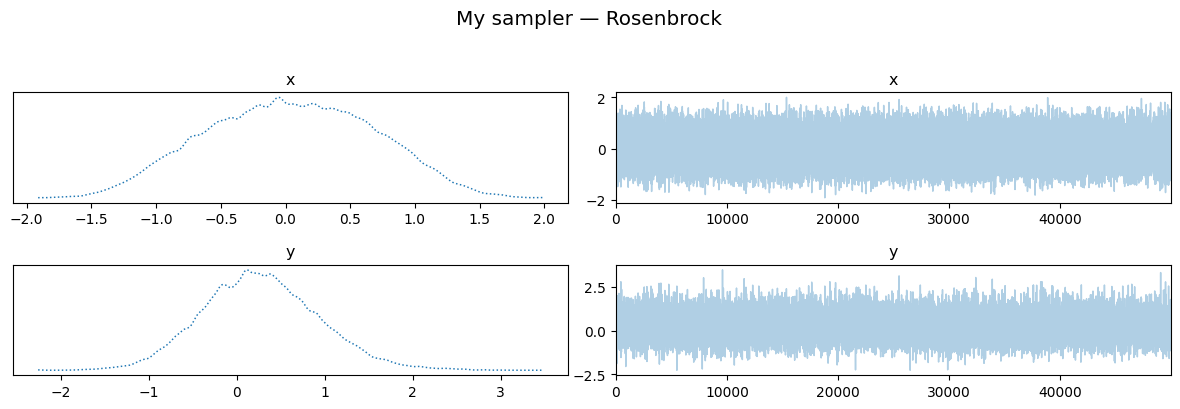

My sampler Trace Plots — Neal's Funnel:


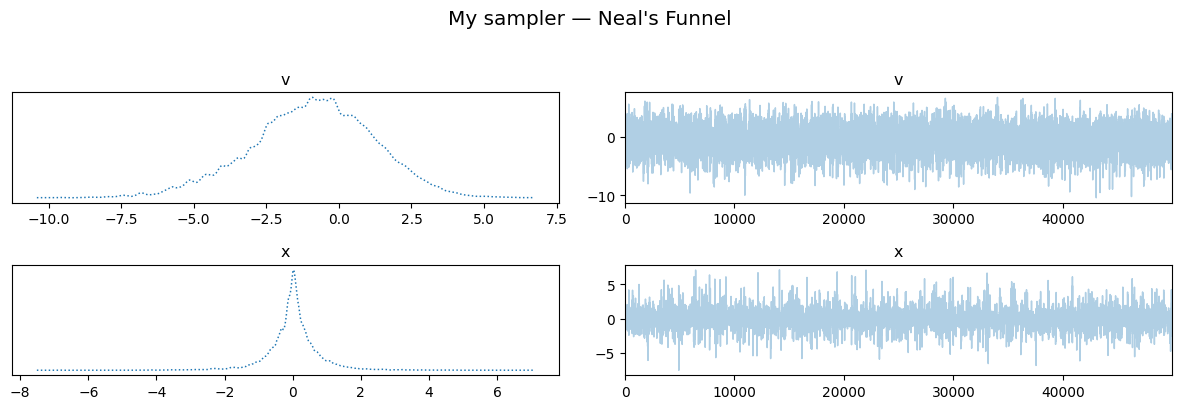

In [25]:
# =========================
# Trace plots — Rosenbrock (My sampler)
# =========================
var_names = ["x", "y"]

my_idata_rb = samples_to_inference_data(my_samples_rb, var_names)

print("My sampler Trace Plots — Rosenbrock:")
az.plot_trace(my_idata_rb, combined=True, figsize=(12, 4))
plt.suptitle("My sampler — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

# =========================
# Trace plots — Neal's Funnel (My sampler)
# =========================
var_names_fn = ["v", "x"]   # funnel position = [v, x]
my_idata_fn = samples_to_inference_data(my_samples_fn, var_names_fn)

print("My sampler Trace Plots — Neal's Funnel:")
az.plot_trace(my_idata_fn, combined=True, figsize=(12, 4))
plt.suptitle("My sampler — Neal's Funnel", y=1.02)
plt.tight_layout()
plt.show()

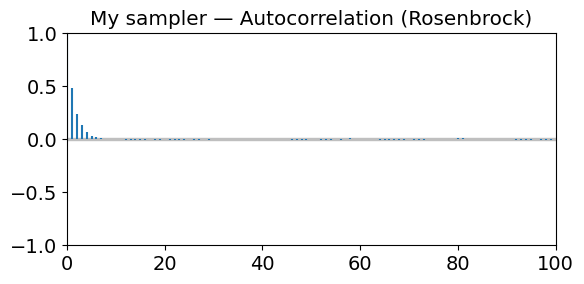

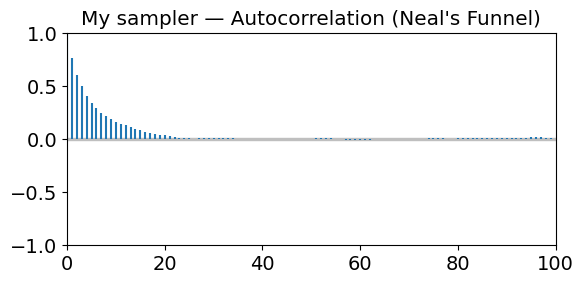

In [26]:
# =========================
# Autocorrelation — Rosenbrock (My sampler)
# =========================
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
az.plot_autocorr(my_idata_rb, ax=ax, combined=True)
ax.set_title("My sampler — Autocorrelation (Rosenbrock)")
plt.tight_layout()
plt.show()


# =========================
# Autocorrelation — Neal's Funnel (My sampler)
# =========================
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
az.plot_autocorr(my_idata_fn, ax=ax, combined=True)
ax.set_title("My sampler — Autocorrelation (Neal's Funnel)")
plt.tight_layout()
plt.show()

In [27]:
import numpy as np
import pandas as pd
# -------------------------
# Helper: compute ESS from samples (n_samples, 2)
# -------------------------
def compute_ess(samples, var_names):
    idata = samples_to_inference_data(samples, var_names)
    # az.ess returns xarray; convert to python floats
    ess = az.ess(idata, var_names=var_names)
    ess_dict = {name: float(ess[name].values) for name in var_names}
    ess_min = min(ess_dict.values())
    return ess_dict, ess_min


# -------------------------
# One ablation run
# -------------------------
def run_one_ablation(
    key,
    log_prob_fn,
    initial_pos,
    n_samples,
    var_names,
    sigma_local,
    p_global,
    sigma_global,
):
    samples, aux = run_my_sampler_mixture_rwmh(
        key,
        log_prob_fn,
        initial_pos,
        n_samples=n_samples,
        sigma_local=sigma_local,
        p_global=p_global,
        sigma_global=sigma_global,
        return_aux=True,
    )

    ess_dict, ess_min = compute_ess(samples, var_names)

    row = {
        "sigma_local": tuple(map(float, np.asarray(sigma_local).tolist())),
        "p_global": float(p_global),
        "sigma_global": float(sigma_global),
        "acceptance_rate": float(aux["acceptance_rate"]),
        "global_used_rate": float(aux["global_used_rate"]),
        "ess_min": float(ess_min),
    }
    for k, v in ess_dict.items():
        row[f"ess_{k}"] = float(v)

    return row


# -------------------------
# Grid ablation runner
# -------------------------
def run_ablation_grid(
    seed,
    log_prob_fn,
    initial_pos,
    n_samples,
    var_names,
    grid,   # list of dicts: {"sigma_local":(...), "p_global":..., "sigma_global":...}
    name="",
):
    rows = []
    base_key = jr.PRNGKey(seed)

    for i, cfg in enumerate(grid):
        key_i = jr.fold_in(base_key, i)  # deterministic, unique per config
        row = run_one_ablation(
            key_i,
            log_prob_fn,
            initial_pos,
            n_samples,
            var_names,
            sigma_local=cfg["sigma_local"],
            p_global=cfg["p_global"],
            sigma_global=cfg["sigma_global"],
        )
        row["target"] = name
        row["config_id"] = i
        rows.append(row)

    df = pd.DataFrame(rows)

    # Sort so best (by ess_min) floats to top
    df = df.sort_values(by=["ess_min"], ascending=False).reset_index(drop=True)
    return df


In [28]:
# =========================
# Ablation — Rosenbrock
# =========================
rb_initial = jnp.array([0.0, 0.0])
rb_var_names = ["x", "y"]
n_samples_ablation = 30_000  # ablation 用 30k 通常足够快

# baseline (用你当前“最好”的参数填)
rb_base = {"sigma_local": (1.0, 1.0), "p_global": 0.1, "sigma_global": 1.0}

rb_grid = []

# (A) p_global ablation (limiting case p=0)
for p in [0.0, 0.05, 0.1, 0.2, 0.5]:
    rb_grid.append({"sigma_local": rb_base["sigma_local"], "p_global": p, "sigma_global": rb_base["sigma_global"]})

# (B) sigma_global ablation
for sg in [0.5, 1.0, 2.0, 5.0]:
    rb_grid.append({"sigma_local": rb_base["sigma_local"], "p_global": rb_base["p_global"], "sigma_global": sg})

# (C) sigma_local ablation
for sl in [(0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0)]:
    rb_grid.append({"sigma_local": sl, "p_global": rb_base["p_global"], "sigma_global": rb_base["sigma_global"]})

df_rb = run_ablation_grid(
    seed=42,
    log_prob_fn=log_prob_rosenbrock,
    initial_pos=rb_initial,
    n_samples=n_samples_ablation,
    var_names=rb_var_names,
    grid=rb_grid,
    name="Rosenbrock",
)

display(df_rb.head(10))


,sigma_local,p_global,sigma_global,acceptance_rate,global_used_rate,ess_min,ess_x,ess_y,target,config_id
0,"(0.5, 0.5)",0.10,1.0,0.777100,0.101967,19295.356878,19295.356878,21046.735980,Rosenbrock,9
1,"(1.0, 1.0)",0.10,0.5,0.532033,0.102567,11308.839113,11308.839113,12025.622101,Rosenbrock,5
2,"(1.0, 1.0)",0.05,1.0,0.502400,0.049967,10842.370893,10842.370893,11608.407514,Rosenbrock,1
3,"(1.0, 1.0)",0.10,1.0,0.503167,0.101167,10758.372337,10758.372337,11305.414669,Rosenbrock,10
4,"(1.0, 1.0)",0.10,1.0,0.497600,0.099433,10260.099283,10260.099283,10852.249223,Rosenbrock,6
5,"(1.0, 1.0)",0.50,1.0,0.505867,0.496200,10212.133520,10212.133520,11669.895186,Rosenbrock,4
6,"(1.0, 1.0)",0.20,1.0,0.499633,0.198067,10132.601484,10132.601484,11526.476245,Rosenbrock,3
7,"(1.0, 1.0)",0.00,1.0,0.499833,0.000000,10022.715815,10022.715815,10373.388565,Rosenbrock,0
8,"(1.0, 1.0)",0.10,1.0,0.497867,0.099533,9990.800828,9990.800828,11171.891559,Rosenbrock,2
9,"(1.0, 1.0)",0.10,2.0,0.477367,0.095367,9627.765685,9627.765685,10612.513116,Rosenbrock,7


In [29]:
# =========================
# Ablation — Neal's Funnel
# =========================
fn_initial = jnp.array([0.0, 0.0])  # [v, x]
fn_var_names = ["v", "x"]
n_samples_ablation = 30_000

# baseline (用你当前“最好”的参数填)
fn_base = {"sigma_local": (5.0, 0.8), "p_global": 0.5, "sigma_global": 3.0}

fn_grid = []

# (A) p_global ablation (limiting case p=0)
for p in [0.0, 0.1, 0.25, 0.5, 0.75]:
    fn_grid.append({"sigma_local": fn_base["sigma_local"], "p_global": p, "sigma_global": fn_base["sigma_global"]})

# (B) sigma_global ablation
for sg in [1.0, 2.0, 3.0, 5.0, 8.0]:
    fn_grid.append({"sigma_local": fn_base["sigma_local"], "p_global": fn_base["p_global"], "sigma_global": sg})

# (C) sigma_local ablation (分别调 v 和 x 的步长幅度)
for sl in [(3.0, 0.6), (5.0, 0.8), (7.0, 1.0)]:
    fn_grid.append({"sigma_local": sl, "p_global": fn_base["p_global"], "sigma_global": fn_base["sigma_global"]})

df_fn = run_ablation_grid(
    seed=42,
    log_prob_fn=log_prob_funnel,
    initial_pos=fn_initial,
    n_samples=n_samples_ablation,
    var_names=fn_var_names,
    grid=fn_grid,
    name="Neal's Funnel",
)

display(df_fn.head(10))


,sigma_local,p_global,sigma_global,acceptance_rate,global_used_rate,ess_min,ess_v,ess_x,target,config_id
0,"(5.0, 0.8)",0.50,1.0,0.464500,0.500333,5730.270152,5730.270152,12224.310902,Neal's Funnel,5
1,"(3.0, 0.6)",0.50,3.0,0.335833,0.503833,4218.738246,4218.738246,7995.886013,Neal's Funnel,10
2,"(5.0, 0.8)",0.50,2.0,0.326800,0.498833,4047.758840,4047.758840,8218.889077,Neal's Funnel,6
3,"(5.0, 0.8)",0.00,3.0,0.286867,0.000000,3512.466630,3512.466630,6951.612562,Neal's Funnel,0
4,"(5.0, 0.8)",0.10,3.0,0.281467,0.098900,3365.656953,3365.656953,6283.811303,Neal's Funnel,1
5,"(5.0, 0.8)",0.50,3.0,0.258967,0.494533,3295.879880,3295.879880,5698.584015,Neal's Funnel,7
6,"(5.0, 0.8)",0.25,3.0,0.270833,0.246300,3179.515726,3179.515726,6479.063602,Neal's Funnel,2
7,"(5.0, 0.8)",0.50,3.0,0.255000,0.498767,2861.489780,2861.489780,6347.993267,Neal's Funnel,11
8,"(5.0, 0.8)",0.75,3.0,0.245567,0.750533,2563.872992,2563.872992,5688.914850,Neal's Funnel,4
9,"(7.0, 1.0)",0.50,3.0,0.214467,0.501933,2519.593893,2519.593893,5360.415296,Neal's Funnel,12


In [30]:
print("Top configs — Rosenbrock (by ess_min):")
display(df_rb[["config_id","sigma_local","p_global","sigma_global","acceptance_rate","global_used_rate","ess_x","ess_y","ess_min"]].head(8))

print("Top configs — Neal's Funnel (by ess_min):")
display(df_fn[["config_id","sigma_local","p_global","sigma_global","acceptance_rate","global_used_rate","ess_v","ess_x","ess_min"]].head(8))

Top configs — Rosenbrock (by ess_min):


,config_id,sigma_local,p_global,sigma_global,acceptance_rate,global_used_rate,ess_x,ess_y,ess_min
0,9,"(0.5, 0.5)",0.10,1.0,0.777100,0.101967,19295.356878,21046.735980,19295.356878
1,5,"(1.0, 1.0)",0.10,0.5,0.532033,0.102567,11308.839113,12025.622101,11308.839113
2,1,"(1.0, 1.0)",0.05,1.0,0.502400,0.049967,10842.370893,11608.407514,10842.370893
3,10,"(1.0, 1.0)",0.10,1.0,0.503167,0.101167,10758.372337,11305.414669,10758.372337
4,6,"(1.0, 1.0)",0.10,1.0,0.497600,0.099433,10260.099283,10852.249223,10260.099283
5,4,"(1.0, 1.0)",0.50,1.0,0.505867,0.496200,10212.133520,11669.895186,10212.133520
6,3,"(1.0, 1.0)",0.20,1.0,0.499633,0.198067,10132.601484,11526.476245,10132.601484
7,0,"(1.0, 1.0)",0.00,1.0,0.499833,0.000000,10022.715815,10373.388565,10022.715815


Top configs — Neal's Funnel (by ess_min):


,config_id,sigma_local,p_global,sigma_global,acceptance_rate,global_used_rate,ess_v,ess_x,ess_min
0,5,"(5.0, 0.8)",0.50,1.0,0.464500,0.500333,5730.270152,12224.310902,5730.270152
1,10,"(3.0, 0.6)",0.50,3.0,0.335833,0.503833,4218.738246,7995.886013,4218.738246
2,6,"(5.0, 0.8)",0.50,2.0,0.326800,0.498833,4047.758840,8218.889077,4047.758840
3,0,"(5.0, 0.8)",0.00,3.0,0.286867,0.000000,3512.466630,6951.612562,3512.466630
4,1,"(5.0, 0.8)",0.10,3.0,0.281467,0.098900,3365.656953,6283.811303,3365.656953
5,7,"(5.0, 0.8)",0.50,3.0,0.258967,0.494533,3295.879880,5698.584015,3295.879880
6,2,"(5.0, 0.8)",0.25,3.0,0.270833,0.246300,3179.515726,6479.063602,3179.515726
7,11,"(5.0, 0.8)",0.50,3.0,0.255000,0.498767,2861.489780,6347.993267,2861.489780
